In [3]:
# import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,DenseFeatures


from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

tf.__version__

'2.11.1'

In [4]:
cateCols=['sla','product_type','brand','service_type','incident_type']
numbericCols=['open_to_close_hour','response_to_resolved_hour']

unusedCols=['severity_id','severity_name','label_multi_severity']
labelCol='label_binary_severity'


model_dir='model_binary'

In [5]:
# Load data from BigQuery
projectId='pongthorn'
dataset_id='DemoSMartDW'

In [6]:
train_name='train_incident'
validation_name='validation_incident'
test_name='test_incident'

In [7]:

def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 df[labelCol]=df[labelCol].astype('int64')   
 return df

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
 df[labelCol]=df[labelCol].astype('int64')   
 return df

In [8]:
train_table_id=f"{projectId}.{dataset_id}.{train_name}"
val_tabel_id=f"{projectId}.{dataset_id}.{validation_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"

client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
val=load_data_bq(f"SELECT * FROM {val_tabel_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")


# root_path='../../data'    
# train = load_ml_data(f"{root_path}/{train_name}.csv")
# val=load_ml_data(f"{root_path}/{validation_name}.csv")
# test =load_ml_data(f"{root_path}/{test_name}.csv")

print(train.shape)
print(train.info())
print(val.shape)
print(test.shape)


(1814, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814 entries, 0 to 1813
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sla                        1814 non-null   object 
 1   product_type               1814 non-null   object 
 2   brand                      1814 non-null   object 
 3   service_type               1814 non-null   object 
 4   incident_type              1814 non-null   object 
 5   open_to_close_hour         1814 non-null   float64
 6   response_to_resolved_hour  1814 non-null   float64
 7   label_binary_severity      1814 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 113.5+ KB
None
(227, 8)
(227, 8)


In [9]:
labelList=list(train[labelCol].unique())
print(labelList)
nLabel=len(labelList)
print(f"No target label : {nLabel}")

# sr_predict=df.iloc[-1,:]
# df=df.iloc[0:len(df)-1,:]
                 
print(train.info())
train.tail()

[1, 0]
No target label : 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814 entries, 0 to 1813
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sla                        1814 non-null   object 
 1   product_type               1814 non-null   object 
 2   brand                      1814 non-null   object 
 3   service_type               1814 non-null   object 
 4   incident_type              1814 non-null   object 
 5   open_to_close_hour         1814 non-null   float64
 6   response_to_resolved_hour  1814 non-null   float64
 7   label_binary_severity      1814 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 113.5+ KB
None


,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,label_binary_severity
1809,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,76.283333,1.316667,0
1810,24x7 4Hrs Response Time,Software,Trend Micro,Request,OS / Firmware,1193.283333,1193.283333,0
1811,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,24.366667,22.050000,0
1812,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,308.166667,308.033333,0
1813,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,5.483333,5.483333,0


In [10]:
def CalPctEachTargetClass(dfx,colSev,colPctSev):
    dfClassSummary=dfx.groupby([labelCol]).size().to_frame(colSev)
    dfClassSummary[colPctSev]= dfClassSummary[colSev]/dfClassSummary[colSev].sum() *100
    dfClassSummary=dfClassSummary.round(0)
    return dfClassSummary

pctDF1=CalPctEachTargetClass(train,'Train-No-Severity','Train-%-Severity')
pctDF2=CalPctEachTargetClass(val,'Val-No-Severity','Val-%-Severity')
pdcDF3=CalPctEachTargetClass(test,'Test-No-Severity','Test-%-Severity')
pctDF=pd.concat([pctDF1,pctDF2,pdcDF3],axis=1)

pctDF

,Train-No-Severity,Train-%-Severity,Val-No-Severity,Val-%-Severity,Test-No-Severity,Test-%-Severity
label_binary_severity,,,,,,
0,852,47.0,113,50.0,107,47.0
1,962,53.0,114,50.0,120,53.0


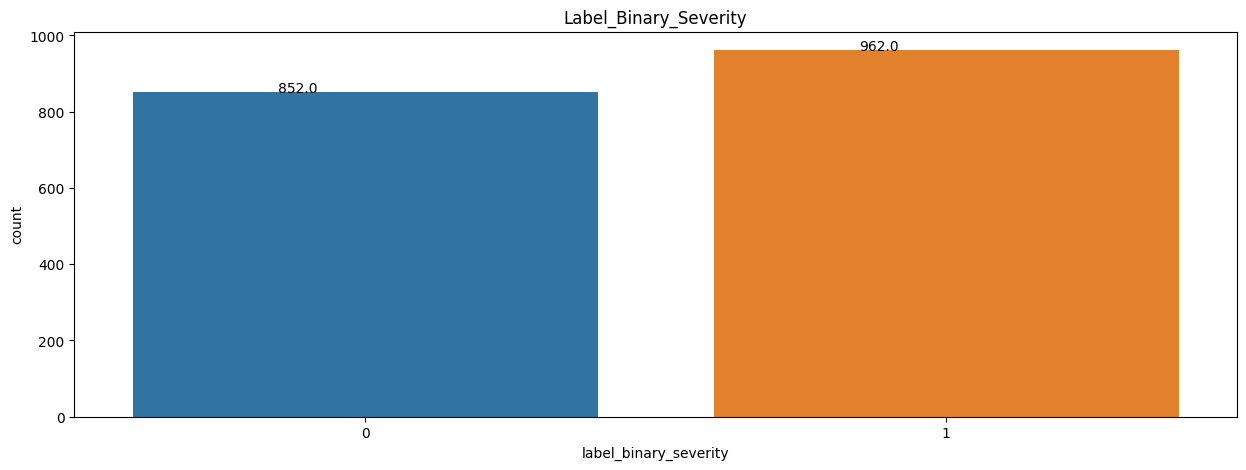

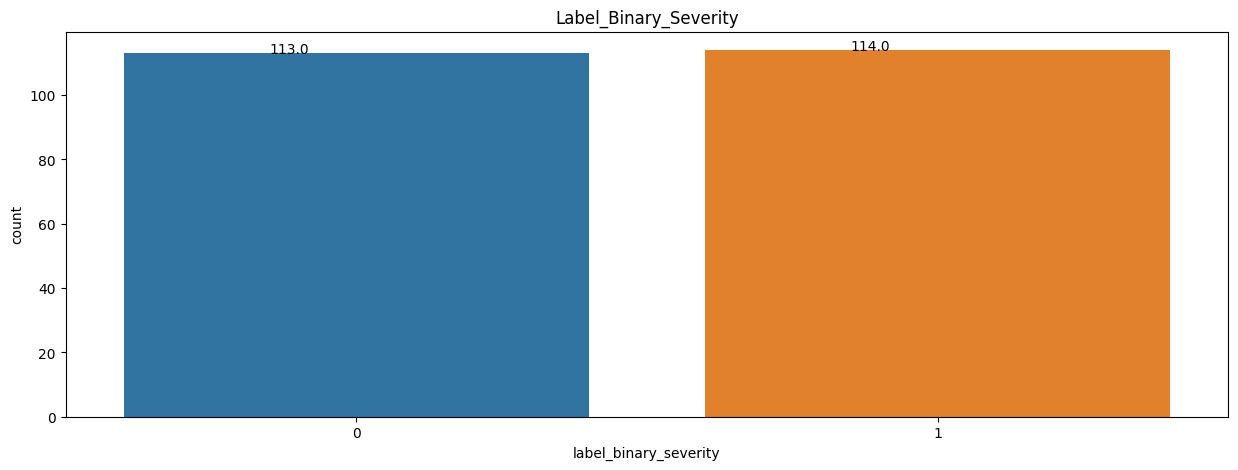

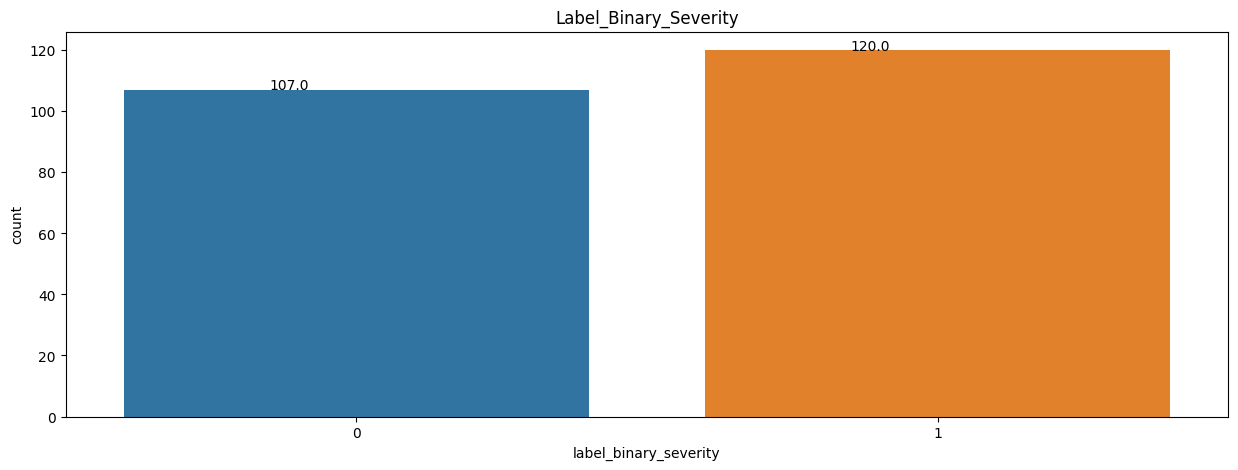

In [11]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=labelCol, data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(labelCol.title())
    plt.show()
    
plot_class(train)
plot_class(val)
plot_class(test)

In [12]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def binary_label_df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop(labelCol)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [13]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [14]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))
     

# Process Data 

In [15]:
batch_size =32
train_ds = binary_label_df_to_dataset (train, batch_size=batch_size)
val_ds = binary_label_df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = binary_label_df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [16]:
all_inputs = []
encoded_features = []

numInputFeatToInitNodeUnit=0

In [17]:
# Numeric features.
for header in numbericCols:
  stat_data=train[header].describe()
  print(f"header: Mean={stat_data['mean']} and Std={stat_data['std']}") 
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

numInputFeatToInitNodeUnit=numInputFeatToInitNodeUnit+len(numbericCols)

header: Mean=96.70577912532157 and Std=264.30857031412927
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
header: Mean=69.23291988239617 and Std=210.15946331055562


In [18]:
# Categorical features encoded as string.
categorical_cols = cateCols
for header in categorical_cols:
  listCateItem=train[header].unique()
  noCateItem=len(listCateItem)
  numInputFeatToInitNodeUnit=numInputFeatToInitNodeUnit+noCateItem +1  # last 1 is unknow
    
  print(f"{header} = {noCateItem} : {listCateItem}")
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
                                        
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


print(f"Total column to initialize first node input: {numInputFeatToInitNodeUnit}")

sla = 7 : ['24x7 4Hrs Resolution Time' '8x5 4Hrs Response Time'
 '24x7 6Hrs Resolution Time' '24x7 4Hrs Response Time'
 '9x5xNBD 4Hrs Response Time' '24x7 6Hrs Response Time' 'Non MA']
product_type = 10 : ['Server' 'Software' 'Other' 'Firewall' 'Hardware' 'Storage' 'Switch'
 'Access Point' 'Security' 'Tape Library']
brand = 23 : ['IBM' 'Microsoft' 'F5' 'Nutanix' 'CheckPoint' 'Broadcom' 'CIMCO-CMMS'
 'eUnite' 'Fortinet' 'EMC' 'HPE' 'YIP' 'DELL' 'Cisco' 'SAPB1' 'Veeam'
 'NetApp' 'Oracle' 'VMWare' 'Red Hat' 'Veritas' 'Palo Alto' 'Trend Micro']
service_type = 2 : ['Incident' 'Request']
incident_type = 21 : ['Hard Disk Drive Failure' 'General Incident' 'Software'
 'Network Cable Failure' 'Maintenance System' 'Upgrade Software'
 'Network Adapter Failure' 'Report' 'Memory Failure'
 'System Board Failure' 'Controller/Node Failure' 'CPU Failure'
 'Network Card Failure' 'Power Supply Failure' 'Cache Battery Failure'
 'Other Failure' 'OS / Firmware' 'Configuration Change' 'Battery Failure'
 'Fan 

In [19]:
all_features = tf.keras.layers.concatenate(encoded_features)

x = tf.keras.layers.Dense(numInputFeatToInitNodeUnit, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.1)(x)

# x = tf.keras.layers.Dense(32, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.1)(x)

output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

#model.summary()


In [20]:
EPOCHS = 100
BATCH_SIZE = 32


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history =model.fit(train_ds, validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks = [early_stopping])
# history =model.fit(train_ds,verbose=1,validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE)


Epoch 1/100
57/57 [==============================] - 3s 14ms/step - loss: 0.6357 - accuracy: 0.5860 - val_loss: 0.5545 - val_accuracy: 0.7048
Epoch 2/100
57/57 [==============================] - 0s 5ms/step - loss: 0.5251 - accuracy: 0.7161 - val_loss: 0.4793 - val_accuracy: 0.7533
Epoch 3/100
57/57 [==============================] - 0s 5ms/step - loss: 0.4754 - accuracy: 0.7486 - val_loss: 0.4492 - val_accuracy: 0.7577
Epoch 4/100
57/57 [==============================] - 0s 4ms/step - loss: 0.4553 - accuracy: 0.7558 - val_loss: 0.4389 - val_accuracy: 0.7797
Epoch 5/100
57/57 [==============================] - 0s 5ms/step - loss: 0.4440 - accuracy: 0.7646 - val_loss: 0.4338 - val_accuracy: 0.7797
Epoch 6/100
57/57 [==============================] - 0s 5ms/step - loss: 0.4350 - accuracy: 0.7674 - val_loss: 0.4301 - val_accuracy: 0.7797
Epoch 7/100
57/57 [==============================] - 0s 4ms/step - loss: 0.4296 - accuracy: 0.7778 - val_loss: 0.4316 - val_accuracy: 0.7797
Epoch 8/100


In [21]:
loss, accuracy = model.evaluate(val_ds)
print("Average Accuracy on Eveluation", accuracy)
loss, accuracy = model.evaluate(test_ds)
print("Average Accuracy  on Test", accuracy)
     

8/8 [==============================] - 0s 5ms/step - loss: 0.3989 - accuracy: 0.7841
Average Accuracy on Eveluation 0.784140944480896
8/8 [==============================] - 0s 5ms/step - loss: 0.4889 - accuracy: 0.7621
Average Accuracy  on Test 0.7621145248413086


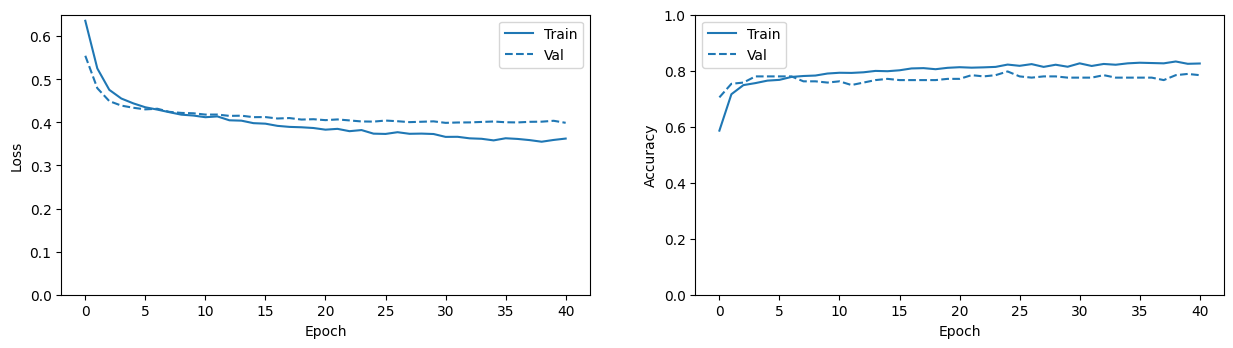

In [22]:
plt.figure(figsize=(15,8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

In [ ]:
model.save(model_dir)
